##

In [96]:
# Name :- Naman Limani 
# Net Id :- 2833

# Import necessary libraries

In [50]:
# Import necessary libraries
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import seaborn as sns
# Captum for explainability methods
from captum.attr import IntegratedGradients, LayerGradCam
from captum.attr import visualization as viz

## Define the path to your dataset

In [51]:
# Define the path to your dataset
data_dir = '/Users/namanlimani/Downloads/subset'

# This code defines a set of image transformations that are applied to images before they are input to the model during training or inference. These transformations include resizing the image, converting it to a tensor, and normalizing it
# This ensures that the input images are properly formatted for a pre-trained model, like ResNet or VGG, and improves model performance and   training stability.

In [52]:
# Define transformations for images: resizing, normalization, etc.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#  Load training and test sets from the local directory

In [53]:
# Load training and test sets from the local directory
train_dataset = ImageFolder(root=f'{data_dir}/train', transform=transform)
test_dataset = ImageFolder(root=f'{data_dir}/test', transform=transform)

# Create DataLoaders for batch processing

In [54]:
# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display a sample image from the training set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


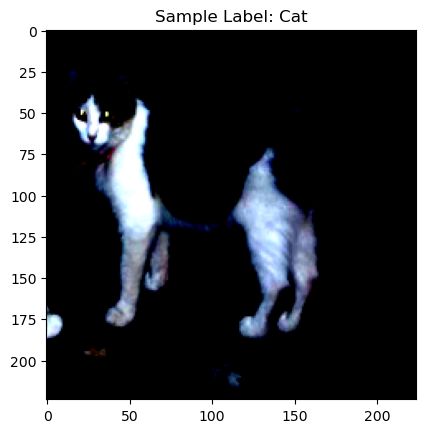

In [55]:
# Display a sample image from the training set
sample_image, sample_label = next(iter(train_loader))
plt.imshow(sample_image[0].permute(1, 2, 0))
plt.title(f'Sample Label: {"Cat" if sample_label[0] == 0 else "Dog"}')
plt.show()

#  This code defines a Convolutional Neural Network (CNN) model using a pre-trained ResNet-18 architecture from PyTorch's torchvision.models module, and it modifies the final fully connected layer to adapt the model for binary classification (in this case, for classifying cats vs. dogs)


In [56]:
### CNN Model Definition ###
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification (cat vs dog)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# This code defines the loss function, optimizer, and learning rate scheduler for training your model


In [58]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# This function train_model is designed to train and validate a neural network model over several epochs
# The function trains a model over multiple epochs and validates it after each epoch.
# It tracks the best model based on validation accuracy and restores it at the end of training.
# Key elements such as gradient management, forward/backward passes, and learning rate adjustments are handled in this loop.

In [59]:
### Training the Model ###

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it improves
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training the model

In [60]:
# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 3.1434 Acc: 0.5310
test Loss: 1.6407 Acc: 0.4850

Epoch 1/4
----------
train Loss: 1.0293 Acc: 0.5035
test Loss: 0.8003 Acc: 0.5000

Epoch 2/4
----------
train Loss: 0.7747 Acc: 0.5085
test Loss: 0.7037 Acc: 0.5080

Epoch 3/4
----------
train Loss: 0.7281 Acc: 0.5210
test Loss: 0.7406 Acc: 0.5440

Epoch 4/4
----------
train Loss: 0.7059 Acc: 0.5460
test Loss: 1.1848 Acc: 0.5400

Training complete in 14m 17s
Best val Acc: 0.5440


In [61]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


# This function visualize_with_heatmap is designed to visualize attributions (such as Grad-CAM or Integrated Gradients) by overlaying them on top of the original image using a heatmap. 
# This function visualizes attributions as heatmaps, overlaying them on the original image.
# It handles the necessary preprocessing like denormalizing the input image, resizing the heatmap, and normalizing the heatmap values.
# The result is a visual representation of which parts of the image were most important for the model's prediction

In [62]:

import torch.nn.functional as F
import cv2  # We will use OpenCV for better heatmap scaling

def visualize_with_heatmap(attributions, original_image, method="Attributions", filename=None):
    # Convert the original image to numpy format for plotting
    original_image = original_image.cpu().detach().numpy().transpose(1, 2, 0)

    # Normalize the original image for visualization (undo normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    original_image = std * original_image + mean
    original_image = np.clip(original_image, 0, 1)

    # Initialize heatmap
    heatmap = None

    # If attributions are for Integrated Gradients or Grad-CAM
    if attributions.ndim == 4:  # Should be [1, 1, 224, 224] or [1, 1, 7, 7] after adjustments
        heatmap = attributions.squeeze().cpu().detach().numpy()  # Convert to numpy format

        # If heatmap is small (7x7 from Grad-CAM), we upscale it to match the image size
        if heatmap.shape != (224, 224):
            heatmap = cv2.resize(heatmap, (224, 224))  # Resize to 224x224

        # Normalize the heatmap for better visualization (scale between 0 and 1)
        heatmap = np.maximum(heatmap, 0)  # ReLU to keep positive attributions
        heatmap /= np.max(heatmap)  # Normalize to [0, 1]

    else:
        raise ValueError("Attributions should have 4 dimensions.")

    # Plot the original image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    # Plot the heatmap
    ax[1].imshow(original_image)
    ax[1].imshow(heatmap, cmap='jet', alpha=0.5)  # Overlaying heatmap with jet colormap
    ax[1].axis('off')
    ax[1].set_title(f'{method} Heatmap')

    plt.tight_layout()
     # Save the heatmap as a PNG file if filename is provided
    if filename:
        plt.savefig(filename)
        print(f"Heatmap saved as {filename}")
    plt.show()

# This function integrated_gradients implements the Integrated Gradients (IG) method, which is a popular interpretability technique used to attribute the importance of each input feature (e.g., pixel) to a specific model prediction.
# This function computes attributions using the Integrated Gradients method for a given input_image and target_class.
# It reduces the color channels (R, G, B) to a single-channel heatmap, which can be used to visualize which parts of the image were most influential for the model's prediction.
# The number of steps (n_steps=200) controls the resolution of the approximation during integration.

In [63]:

def integrated_gradients(model, input_image, target_class):
    model.eval()
    ig = IntegratedGradients(model)
    attributions = ig.attribute(input_image, target=target_class, n_steps=200)
    
    # Check that attributions have 4 dimensions (batch_size, channels, height, width)
    if attributions.ndim == 4 and attributions.shape[1] == 3:  # [1, 3, 224, 224]
        # Reduce across color channels (take the mean to convert to 2D heatmap)
        attributions = torch.mean(attributions, dim=1, keepdim=True)  # Now shape is [1, 1, 224, 224]
        return attributions
    else:
        raise ValueError("Integrated Gradients should output 4 dimensions with 3 channels.")


# This function grad_cam implements the Grad-CAM (Gradient-weighted Class Activation Mapping) method, which is used to visualize the important regions in an input image that contribute to a neural network's decision for a specific target class.
# This function computes Grad-CAM for a given model and input image, targeting the last convolutional layer of the model (layer4).
# The attributions highlight the important regions of the image that contributed to the model's prediction for the target_class.
# The output is a 4D tensor containing the attributions, which can be used to generate a heatmap overlay on the original image.

In [82]:
# Grad-CAM with heatmap

def grad_cam(model, input_image, target_class):
    model.eval()
    layer_gc = LayerGradCam(model, model.layer4)  # Targeting the last layer
    attributions = layer_gc.attribute(input_image, target=target_class)

    # Ensure the output is in the shape [1, 1, 7, 7]
    if attributions.ndim == 4:
        return attributions
    else:
        raise ValueError("Grad-CAM should output 4 dimensions.")

# This code performs Integrated Gradients (IG) attribution for a neural network model and visualizes the results using a custom blue colormap.
# The code uses the Integrated Gradients algorithm to compute and visualize the attributions for a single image with respect to its predicted class.
# A custom blue colormap is used to highlight the important regions in the image, with a heatmap overlay that shows which parts of the image contributed most to the model's decision.
# The original image and the attributions (heatmap) are both saved as images for later use.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


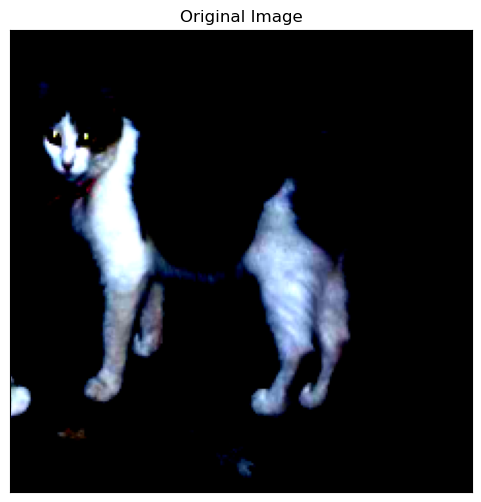

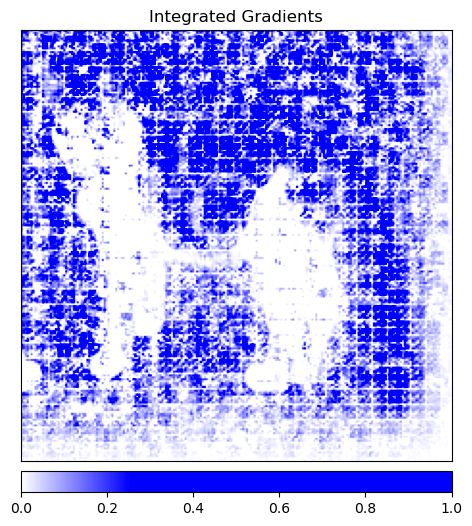

In [76]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom blue colormap
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

# Extract a single image from the batch (e.g., the first image)
single_image = sample_image[0].unsqueeze(0)  # Shape will now be [1, 3, 224, 224]

# Perform a forward pass through the model with the single image
model.eval()  # Set the model to evaluation mode
output = model(single_image)

# Capture the predicted label (class index) for the single image
_, predicted_label = torch.max(output, 1)

# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to the predicted label
attributions_ig = integrated_gradients.attribute(single_image, target=predicted_label, n_steps=40)

# Squeeze the batch dimension and transpose for visualization
single_image_np = np.transpose(single_image.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

# Show the original image for comparison
f1,_ = viz.visualize_image_attr(None, single_image_np, method="original_image", title="Original Image")
f1.savefig('original')
# Visualize attributions using a custom blue colormap
attributions_ig_np = np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
f2,_ = viz.visualize_image_attr(attributions_ig_np, single_image_np, method='heat_map',
                             cmap=default_cmap, show_colorbar=True, sign='positive', title='Integrated Gradients')
f2.savefig('integrated geadient')


# This code is implementing Grad-CAM (Gradient-weighted Class Activation Mapping), a popular technique for visualizing the important regions of an image that contributed to a model's decision. The code computes Grad-CAM attributions, upsamples them to match the input image size, normalizes the attributions, and visualizes them with a heatmap overlay on the original image.
#

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


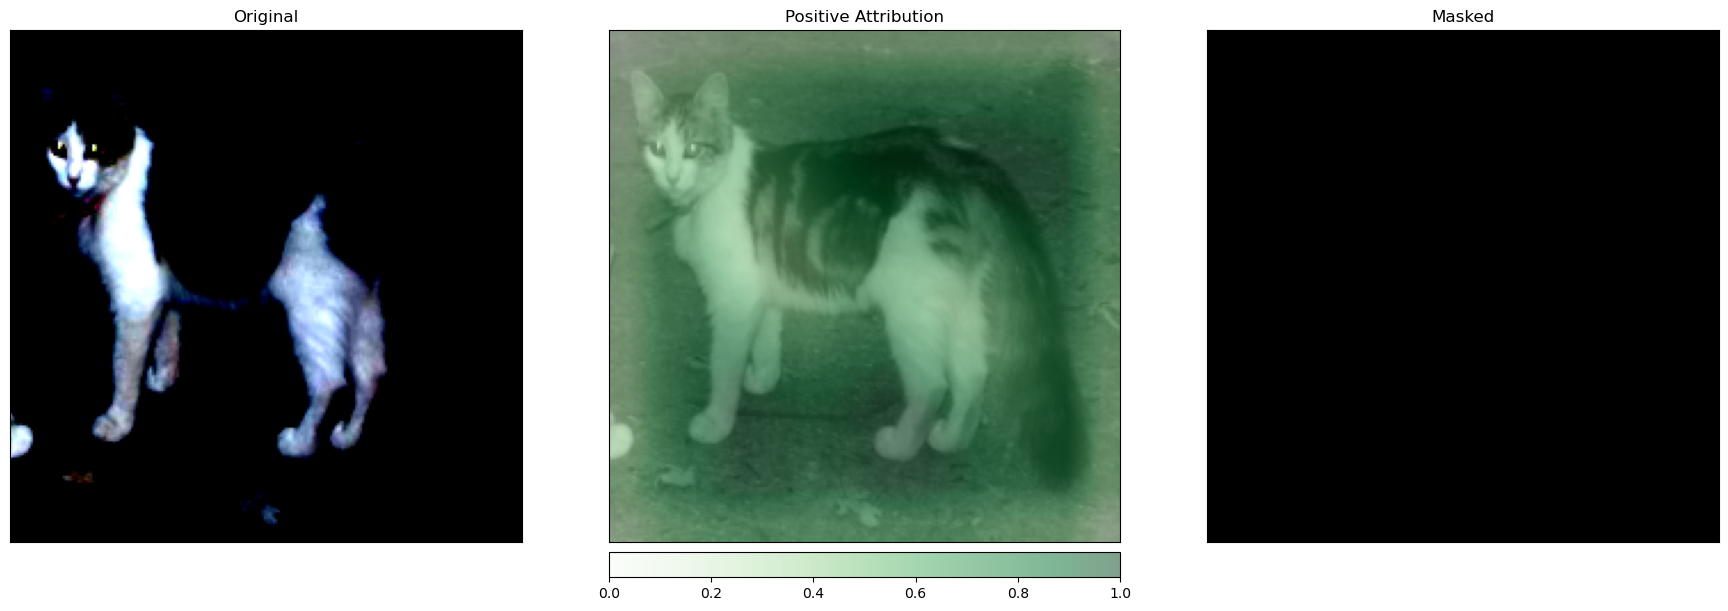

In [92]:
import torch.nn.functional as F

# Initialize LayerGradCam with the specific layer (Layer 3 Block 1 Conv 2)
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)

# Get the Grad-CAM attributions for the predicted label
attributions_lgc = layer_gradcam.attribute(single_image, target=predicted_label)

# Upsample the attributions to match the input image size using torch.nn.functional.interpolate
upsamp_attr_lgc = F.interpolate(attributions_lgc, size=single_image.shape[2:], mode='bilinear', align_corners=False)

# Aggregate channels if necessary (mean across the channels)
upsamp_attr_lgc = torch.mean(upsamp_attr_lgc, dim=1, keepdim=True)

# Take the absolute value of the attributions to avoid negative values
upsamp_attr_lgc = torch.abs(upsamp_attr_lgc)

# Normalize the attributions with a small epsilon to avoid division by zero
epsilon = 1e-8  # Small constant
upsamp_attr_lgc = upsamp_attr_lgc / (torch.max(upsamp_attr_lgc) + epsilon)

# Convert single_image to numpy (removing batch dimension first)
single_image_np = single_image.squeeze(0).cpu().permute(1, 2, 0).numpy()

# Visualize with multiple methods: original, blended heatmap, and masked
f2, _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1, 2, 0).detach().numpy(),
                                      single_image_np,
                                      ["original_image", "blended_heat_map", "masked_image"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))
f3.savefig('Grad Cam')
